In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *

# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
data_path = Path("./data/siim-isic-melanoma-classification/")

In [ ]:
train_df = pd.read_csv(data_path/"train.csv")
test_df = pd.read_csv(data_path/"test.csv")

print(len(train_df), len(test_df))

33126 10982


In [ ]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [ ]:
# extremely unbalanced dataset, most of the images are benign
train_df["target"].value_counts(normalize=True)

0    0.98237
1    0.01763
Name: target, dtype: float64

## Tabular data

In [ ]:
# idx for validation
val_idx = get_valid_index(train_df)
len(val_idx)

6625

In [ ]:
dep_var = 'target'
cat_names = ['sex', 'anatom_site_general_challenge']
cont_names = ['age_approx']
procs = [FillMissing, Categorify, Normalize]
bs=64

In [ ]:
test_data = TabularList.from_df(test_df, path=data_path,
                                cat_names=cat_names, cont_names=cont_names)

tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names,
                                cont_names=cont_names, procs=procs)
            .split_by_idx(val_idx)
            .label_from_df(cols=dep_var)
            .add_test(test_data)
            .databunch(bs=bs))

In [ ]:
# examples
tab_data.show_batch(rows=10)

sex,anatom_site_general_challenge,age_approx_na,age_approx,target
female,lower extremity,False,-1.6641,0
male,lower extremity,False,-0.6195,0
#na#,torso,True,0.0768,0
female,upper extremity,False,-0.9677,0
female,torso,False,0.7732,0
female,torso,False,0.4250,0
male,lower extremity,False,0.7732,0
female,upper extremity,False,-0.9677,0
male,lower extremity,False,-0.9677,0
female,torso,False,0.0768,0


In [ ]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train_df["target"].mean()), 1/train_df["target"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [ ]:
# package everything in a fastai learner, add auc roc score as a metric
learn = tabular_learner(tab_data, layers=[8,8], metrics=[accuracy, ROCAUC()],
                        loss_func=loss_func)

## Training

epoch,train_loss,valid_loss,accuracy,rocauc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


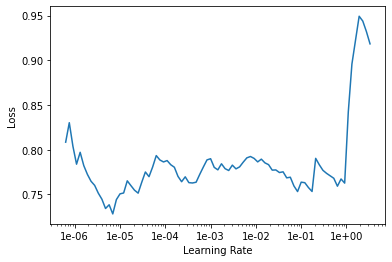

In [ ]:
# find learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# train
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.761437,0.739343,0.293283,0.656587,00:08
1,0.673929,0.661448,0.672906,0.636872,00:06
2,0.631476,0.614779,0.865962,0.689458,00:08
3,0.654370,0.633675,0.963321,0.679780,00:08
4,0.622434,0.634781,0.817208,0.692977,00:08
5,0.621000,0.624831,0.847849,0.708333,00:08
6,0.626121,0.625286,0.870943,0.710524,00:08
7,0.594596,0.617269,0.848906,0.706307,00:07
8,0.623723,0.610537,0.854641,0.707314,00:07
9,0.608752,0.614446,0.848906,0.709546,00:05


## Prediction

In [ ]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
# submit predictions to kaggle
submit = pd.read_csv(data_path/"sample_submission.csv")
submit["target"] = preds[:, 1]
submit.to_csv(data_path/"tab.csv", index=False)